In [1]:
import pandas as pd
import numpy as np
import regex
import gensim
import collections
import multiprocessing
import nltk
nltk.download('punkt')
from ggplot import *
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import time
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import heapq

[nltk_data] Downloading package punkt to /home/ll3165/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/ll3165/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ll3165/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ll3165/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ll3165/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 

In [2]:
# Load and format files

document = pd.read_csv('embed_label.csv',index_col=None)
document.head(5)

,Sentence,Gene1,Gene2
0,"Nicholson e, Lucinda Billingham aa Canc...",MRC,NHS
1,gov -Trial records317 WHO -303 records Cont...,ERCC1,CLC
2,/ Lung Cancer 92 (2016) 1–7ilezs epmas ...,ERCC1,RCC1
3,gov/sites/entrez?db/gene“Primers have been ...,ERCC1,PGK
4,acknowledges NHS funding to theRoyal Ma...,NHS,MRC


In [3]:
#Save the Relations to a txt file
ls_rel=list(document["Sentence"])
# with open("Relations.txt","w") as rels:
#     rels.write(str(ls_rel))

##Count the number of unique words in this list

join_ls="".join(str(ls_rel))
join_ls = join_ls.split(" ")
len(join_ls)
print("There are "+str(len(set(join_ls)))+ " unique words in the relationship sentences")

There are 55380 unique words in the relationship sentences


In [4]:
dat = document

lines = []
for x in dat['Sentence']:
    lines.append(len(list(filter(str.strip ,str(x).split('\n')))))

dat = dat.assign(length = lines)

articles = []
for x in dat['Sentence']:
    for i in range(len(list(filter(str.strip ,str(x).split('\n'))))):
        articles.append(str(x).split('\n')[i])



data = pd.DataFrame({'lines': articles})
print('Cell processing completed!')

Cell processing completed!


In [5]:
# Load Word2vec model trained on fasttext
wv_model = gensim.models.KeyedVectors.load_word2vec_format('wiki.en.bin', binary = True)
vector_sizes1 = 100
my_model = gensim.models.KeyedVectors.load_word2vec_format('fil9.bin', binary = True)
punctuation = "[\t+\.\!\:\/_,$%^*(+\"\')]+|\.[+——()?,.;“”！，。？、\[\]~@#￥%……&*（）：；–•\−\-\uf0fc+\uf0a7]|[0-9]+"
print('Cell processing completed!')

Cell processing completed!


In [6]:
#Remove words with length = 1

X = data[data.columns[0]]
X = pd.Series([regex.sub(punctuation,'', x) for x in X])

print('Cell processing completed!')

Cell processing completed!


In [7]:
X = data[data.columns[0]]
X = pd.Series([regex.sub(punctuation,'', x) for x in X])
X = X.values.astype(str)

X = [word_tokenize(x) for x in X]
print('Cell processing completed!')

Cell processing completed!


In [8]:
print("The number of sentences we are using is "+str(len(X)))
for i in range(len(X)):
    X[i]=[x for x in X[i] if len(x)!=1]



The number of sentences we are using is 10445


In [9]:
# Build train data and labels
tokenizer = Tokenizer(nb_words=60000)
tokenizer.fit_on_texts(articles)
sequences = tokenizer.texts_to_sequences(articles)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

datas = pad_sequences(sequences, maxlen=50) #Try adjust 'maxlen' given number of tokens


Found 36504 unique tokens.


In [10]:
# Build embedding index dictionary and embedding matrix
vector_sizes2 = wv_model.vector_size
vector_size = vector_sizes1 + vector_sizes2

embeddings_index = {}
for i in range(len(wv_model.index2word)):
    word = wv_model.index2word[i]
    coefs = np.asarray(wv_model.vectors[i], dtype='float32')
    embeddings_index[word] = coefs
    
embeddings_index_ = {}
for i in range(len(my_model.index2word)):
    word = my_model.index2word[i]
    coefs = np.asarray(my_model.vectors[i], dtype='float32')
    embeddings_index_[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, vector_size))
for word, i in word_index.items():
    wv_vec = embeddings_index.get(word)

    if wv_vec is not None and word in my_model.wv.vocab:
        embedding_vector = np.append(wv_vec, my_model[word])
    elif wv_vec is not None and word not in my_model.wv.vocab:
        embedding_vector = np.append(wv_vec, np.zeros((1, 100)))
    elif wv_vec is not None and word in my_model.wv.vocab:
        embedding_vector = np.append(np.zeros((1, 300)), my_model[word])

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('Cell processing completed!')

Cell processing completed!


In [11]:
len(embeddings_index['is'])#We used the pretrained weights based on wiki to get the first 300 dimensions of the embedding

300

In [12]:
print(len(datas))#There are the number of embedded sentences
type(datas)

10445


numpy.ndarray

In [13]:
print("Each token is embedded to " + str(len(embedding_matrix[1])))

Each token is embedded to 400


In [14]:
relations = []
for i in range(document.shape[0]):
    g1_ind = str(document["Sentence"][i]).find(document["Gene1"][i])+len(str(document["Gene1"][i]))
    g2_ind = str(document["Sentence"][i]).find(document["Gene2"][i])
    rels = str(document["Sentence"][i])[g1_ind:g2_ind]
    relations.append(rels)

In [15]:
pd.DataFrame(relations).to_csv("relation_sents.tsv",sep="\t",header=False)

In [16]:
sens=document['Sentence']
senss = pd.DataFrame(sens)
ls=[]
for i in range(len(datas)):
    ls.append(datas[i])
df = pd.DataFrame(sens,ls)
# df.to_csv("embedded_Sentence.csv")  #Don't need to run this line if embedded_Sentence.csv exists

In [17]:
embedding_matrix.shape
len(sens[0].split(" "))
embeddings_index[sens[0].split(" ")[4]]#This is a example of our embedding matrix

array([-8.8321e-01,  6.9976e-01, -1.4139e-01, -1.0388e-01,  3.6590e-02,
       -4.0401e-01, -3.5072e-01,  1.5027e-01,  3.7758e-01, -9.3098e-01,
       -1.4068e-01, -5.8853e-01, -8.5381e-01, -1.3935e-01, -3.5133e-01,
       -1.0354e+00, -6.4156e-01,  1.5202e-01,  1.8198e-01,  1.0932e-01,
       -4.8773e-01, -2.4332e-01, -9.9507e-01, -1.1768e+00, -5.4322e-01,
       -7.0625e-01,  1.2839e-01,  9.0030e-02, -2.7746e-01,  3.9156e-01,
       -1.5071e-01,  1.2942e+00, -3.0745e-01,  8.4750e-01, -3.0700e-01,
       -8.8172e-02,  2.7750e-01,  6.7167e-02, -7.7155e-01,  4.5885e-02,
       -2.4569e-01,  1.6925e-01, -1.4908e-01, -4.7433e-01,  4.9512e-01,
        3.4151e-01,  4.0983e-01, -2.5052e-01,  1.2022e-01, -8.0459e-02,
       -3.2406e-01, -8.5819e-01, -1.2316e-01, -4.9544e-01,  6.0271e-01,
        2.8184e-01,  9.2861e-01, -2.2469e-01, -4.2467e-01, -6.1195e-02,
        3.4157e-01,  1.1932e+00,  5.1277e-01,  5.3323e-02,  1.3751e-01,
        7.5240e-01,  2.2526e-01, -1.9910e-02, -3.3799e-01, -1.37

In [18]:
#This function is to calculate the mean embedding of the sentences.
#We averaged across the sentences across the tokens
#The shape of the mean embedding matrix is 10445,400
mean_mat = np.zeros([len(sens),embedding_matrix.shape[1]])

for i in range(len(sens)):
    sums = 0
    splt = str(sens[i]).split(" ")
    for j in range(len(splt)):
        n = 1
        if splt[j] in embeddings_index and splt[j] in embeddings_index_:
            sums = sums+np.append(embeddings_index[splt[j]], embeddings_index_[splt[j]])
            n = n+1
    mean_mat[i]=sums/n
print(mean_mat.shape)

(10445, 400)


In [19]:
relation_mat = np.zeros([len(relations),embedding_matrix.shape[1]])

for i in range(len(relations)):
    sums = 0
    splt = str(relations[i]).split(" ")
    for j in range(len(splt)):
        n = 1
        if splt[j] in embeddings_index and splt[j] in embeddings_index_:
            sums = sums + np.append(embeddings_index[splt[j]], embeddings_index_[splt[j]])
            n = n+1
    relation_mat[i]=sums/n
print(relation_mat.shape)

(10445, 400)


In [20]:
#np.savetxt("relation_embed.tsv", relation_mat, delimiter="\t") #Don't need to run this code if relation_embed.tsv exists

Save to two seperate tsv files and upload to tensorboard and get the visualization result

In [21]:
#save this sentence embedding to disk
np.savetxt("mean_embed.tsv", mean_mat, delimiter="\t")


Simply average the embedding sentences

In [22]:
pd.DataFrame(relation_mat).to_csv("k_means_embed.csv",index=False)

In [23]:
from sklearn.cluster import KMeans
import numpy as np
X = relation_mat
X.shape

(10445, 400)

In [24]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(X)


In [25]:
distence=kmeans.transform(X)
kmeans.labels_.shape
print("The number of sentences in cluster1 is "+str(sum(kmeans.labels_==0)))
print("The number of sentences in cluster2 is "+str(sum(kmeans.labels_==1)))
print("The number of sentences in cluster3 is "+str(sum(kmeans.labels_==2)))

The number of sentences in cluster1 is 1913
The number of sentences in cluster2 is 8396
The number of sentences in cluster3 is 136


In [26]:
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X)


In [27]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y_pred
df['label'] = df['label'].apply(lambda i: str(i))


In [28]:
distence = pd.DataFrame(distence)
y_pred[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [29]:
n_sne = 10445
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=250)
tsne_results = tsne.fit_transform(df.loc[:n_sne,feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10445 samples in 0.239s...
[t-SNE] Computed neighbors for 10445 samples in 51.947s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10445
[t-SNE] Computed conditional probabilities for sample 2000 / 10445
[t-SNE] Computed conditional probabilities for sample 3000 / 10445
[t-SNE] Computed conditional probabilities for sample 4000 / 10445
[t-SNE] Computed conditional probabilities for sample 5000 / 10445
[t-SNE] Computed conditional probabilities for sample 6000 / 10445
[t-SNE] Computed conditional probabilities for sample 7000 / 10445
[t-SNE] Computed conditional probabilities for sample 8000 / 10445
[t-SNE] Computed conditional probabilities for sample 9000 / 10445
[t-SNE] Computed conditional probabilities for sample 10000 / 10445
[t-SNE] Computed conditional probabilities for sample 10445 / 10445
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.676399
[t-SNE] E

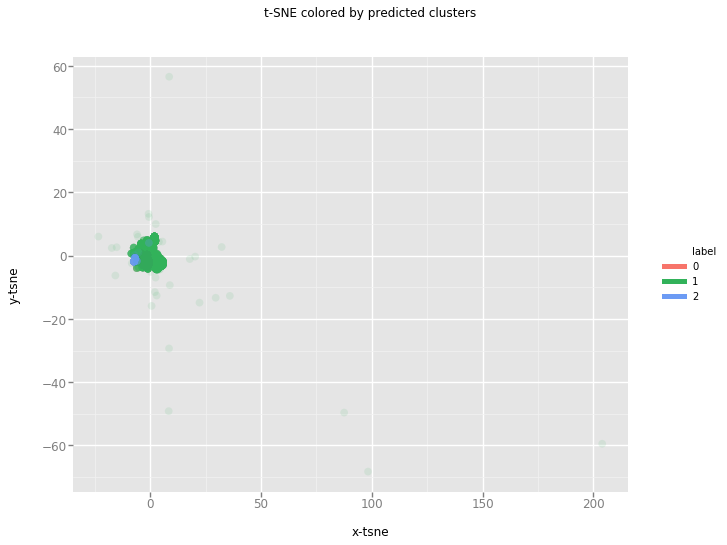

<ggplot: (-9223363260384557361)>

In [30]:
df_tsne = df.loc[:n_sne,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=60,alpha=0.1) \
        + ggtitle("t-SNE colored by predicted clusters")
chart


Then we are going to dive into the center of these clusters and expected to find how the sentences embeddings help

In [31]:
ls=[]
smallest_5 = heapq.nsmallest(5, list(distence.iloc[:,0]))
for i in range(len(smallest_5)):
    index = np.where(distence.iloc[:,0]==smallest_5[i])
    ls.append(index[0][0])
ls

[3263, 5086, 5897, 2155, 827]

In [32]:
document.iloc[ls]

,Sentence,Gene1,Gene2
3263,Alectinib CSF concentration was 63–94% of tha...,CSF,ALK
5086,SOX1 could also inter-fere with Wnt/b-catenin...,SOX1,HCC
5897,Reliable use of PET in primary GTVdeﬁnition r...,PET,SUV
2155,"In particular, the use of EGFR-TKIs in patien...",EGFR,AS
827,Because both AHNAK downregulation and treat...,AHNAK,SOX2


In [33]:
for i in ls:
    print(document["Sentence"][i]+"\n")



 Alectinib CSF concentration was 63–94% of that measured in theplasma, possibly because this agent, unlike crizotinib and another nextgeneration ALK TKI ceritinib, is not a substrate for P-gp

 SOX1 could also inter-fere with Wnt/b-catenin signaling in the development of HCC [6]

 Reliable use of PET in primary GTVdeﬁnition requires a clearly established methodologyparticularly for quantitative determination of the tumouredge, which is typically based on the standardized uptakevalue (SUV), where threshold (or cut-off value) deﬁned as apercentage of maximum SUV or an absolute SUV value isused

 In particular, the use of EGFR-TKIs in patientsharboring EGFR mutations is crucial with the effect of AS becauseFigure 1 Kaplan-Meier Survival Curves of Progression-Free Survival (PFS) and Overall Survival (OS)

   Because both AHNAK downregulation and treatment with a p53 inhibitor increased  the  mRNA  levels  of  SOX2  and  MYC,  we  evaluated  whether  p53 binds directly to the SOX2 and MYC p

In [46]:
# distence = pd.DataFrame(distence)
ls=[]
smallest_5 = list(set(heapq.nsmallest(9, list(distence.iloc[:,1]))))
for i in range(len(smallest_5)):
    index = np.where(distence.iloc[:,1]==smallest_5[i])
    ls.append(index[0][0])
ls


[5922, 6655, 8890, 976, 4373]

In [47]:
document.iloc[ls]


,Sentence,Gene1,Gene2
5922,ALK translocation and EGFR or KRAS mutationsw...,ALK,EGFR
6655,"5,8 ALK translocations and EGFR mutations o...",ALK,EGFR
8890,Three specimens harbored concurrent muta...,PIK3CA,KRAS
976,(C) Cell proliferation of BRE-AS1 stablyovere...,BRE-AS1,NR4A3
4373,"Theseﬁndings suggest that, in vitro and in vi...",MALAT1,STAT3


In [36]:
for i in ls:
    print(document["Sentence"][i]+"\n")


 ALK translocation and EGFR or KRAS mutationswere the most screened molecular analysis

 ALK translocation and EGFR or KRAS mutationswere the most screened molecular analysis

 ALK translocation and EGFR or KRAS mutationswere the most screened molecular analysis

  Three  specimens  harbored  concurrent  mutations  in PIK3CA and either KRAS (n=2) or EGFR (n=1)

  Three  specimens  harbored  concurrent  mutations  in PIK3CA and either KRAS (n=2) or EGFR (n=1)



In [37]:
kmeans = KMeans(n_clusters=10,random_state=0).fit(X)

In [38]:
y_pred = KMeans(n_clusters=10, random_state=0).fit_predict(X)
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y_pred
df['label'] = df['label'].apply(lambda i: str(i))



In [39]:
n_sne = 10445
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=250)
tsne_results = tsne.fit_transform(df.loc[:n_sne,feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10445 samples in 0.264s...
[t-SNE] Computed neighbors for 10445 samples in 55.579s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10445
[t-SNE] Computed conditional probabilities for sample 2000 / 10445
[t-SNE] Computed conditional probabilities for sample 3000 / 10445
[t-SNE] Computed conditional probabilities for sample 4000 / 10445
[t-SNE] Computed conditional probabilities for sample 5000 / 10445
[t-SNE] Computed conditional probabilities for sample 6000 / 10445
[t-SNE] Computed conditional probabilities for sample 7000 / 10445
[t-SNE] Computed conditional probabilities for sample 8000 / 10445
[t-SNE] Computed conditional probabilities for sample 9000 / 10445
[t-SNE] Computed conditional probabilities for sample 10000 / 10445
[t-SNE] Computed conditional probabilities for sample 10445 / 10445
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.898140
[t-SNE] Er

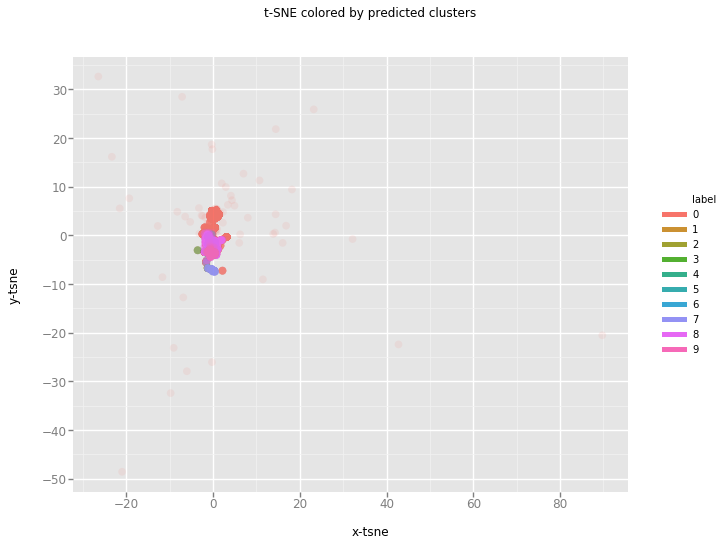

<ggplot: (-9223363260398409917)>

In [40]:
df_tsne = df.loc[:n_sne,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=60,alpha=0.1) \
        + ggtitle("t-SNE colored by predicted clusters")
chart
